# Workshop 1 Practical: Working with Embeddings

During this practical component, you are going to follow a notebook to see how simple it is to do embeddings of text. We are going to do some work on set of sentences. This tutorial requires a basic understanding of Python and Maths. Where possible I will add some external links to help with understanding.


## Setup

### Getting the relevant libraries.

To run the two libraries you are going to need some libraries. You don't need to run this cell below except for the first time. No worries if you do, its not going to do anything bad, but just take some time.

In [115]:
# upgrade pip
!pip install --upgrade pip

# dataframe Libraries
!pip install pandas==1.1.5

# plotting Libraries
!pip install matplotlib==3.3.3
!pip install seaborn==0.11.2

# machine learning framework libraries 
!pip install tensorflow-cpu==2.8.0
!pip install torch==1.11.0

# model framework libraries
!pip install tensorflow-hub==0.12.0
!pip install transformers==4.17.0
!pip install sentence-transformers==2.2.0
!pip install keybert==0.5.1

### Setting up the text we are going to look at

For those of new to this project, you will not have come accross the following lines of text. We use these lines below to show examples of text we can use to calibrate our own understanding of the language models. Its not an exact science, but it shows us what the model is able to pull together, and importantly also seperate.

These text examples are in some cases very close in meaning - but subtly different - such as `text_1` and `text_2`, or slighly different, like text_1 and text_2 in comparison to text_3. Then the other texts are actually very different in meaning like `text_4` and `text_5`. 

Finally we give some sentences that are compounds of the first 5 sentences. This allows us to see how the model deals with additional text. Many of the language models clip sentences that are too long, so that they can continue to process the text in a faster way.

Okay, lets look at the text:

In [1]:
import pandas as pd
import numpy as np

In [2]:
# read in CMS complaints data - should be able to replace with any file 
df = pd.read_csv("CMS_complaints_tagged.csv")

text = df["text"]

In [3]:
text

0     36827   Based on review of records and intervi...
1     28659  Based on interview and record review, t...
2     32143   Based on observation and interview, th...
3     39801  Based on observation, interview, and re...
4     36827   Based on review of records and intervi...
5     32143    Based on review, observation, and int...
6     32143    Based on record review and interview,...
7     28659  Based on observation, interview and rec...
8     39801   Based on record review and interview, ...
9     32143    Based on record review and interview,...
10    32143    36827  Based on review of records and...
11    32143  Based on record review and interview,  ...
12    32143     36827   Based on review of records a...
13    32143  Based upon observation, interview and r...
14    36827  Based on record reviews and interviews,...
Name: text, dtype: object

In [4]:
# text_1 = "My cat only eats Norwegian Salmon, and has never thanked me once."
# text_2 = "My cat only eats Tuna, and has never tried thanked me."
# text_3 = "My dog only eats moose, and has always thanked me every time."
# text_4 = "My friend is looking forward to getting his new graphics card."
# text_5 = "The speed limit is the absolute maximum and does not mean it is safe to drive at that speed irrespective of conditions. Driving at speeds too fast for the road and traffic conditions is dangerous."
# text_6 = text_5 + '. ' + text_1
# text_7 = text_5 + '. ' + text_3
# text_8 = text_5 + '. ' + text_4

# substitute CMS complaint data
text_1 = text[0]
text_2 = text[1]
text_3 = text[2]
text_4 = text[3]
text_5 = text[4]
text_6 = text_5 + '. ' + text_1
text_7 = text_5 + '. ' + text_3
text_8 = text_5 + '. ' + text_4

Lets put that into a pandas dataframe. We are going to use this to create a table later of the embeddings and metrics that we have. This will become more clear as we move through the tutorial.

In [4]:
import pandas as pd
import numpy as np

In [5]:
# text_array = [text_1, text_2, text_3, text_4, text_5, text_6, text_7, text_8]
# text_df = pd.DataFrame(text_array, columns=["text"])

In [6]:
# subsitute CMS data
text_df = pd.DataFrame(text)

In [7]:
text_df

,text
0,36827 Based on review of records and intervi...
1,"28659 Based on interview and record review, t..."
2,"32143 Based on observation and interview, th..."
3,"39801 Based on observation, interview, and re..."
4,36827 Based on review of records and intervi...
5,"32143 Based on review, observation, and int..."
6,"32143 Based on record review and interview,..."
7,"28659 Based on observation, interview and rec..."
8,"39801 Based on record review and interview, ..."
9,"32143 Based on record review and interview,..."


## Difference Metrics

To see the difference between embeddings we are going to need some distance metrics. There are two different types. We will be using a euclidian distance. We can use Numpy's `linalg.norm` do this. We will define a function that does this distance measure.

In [8]:
def distance(emb_1, emb_2):
    return np.linalg.norm(emb_1 - emb_2)

Lets look at some vectors and see the distance between them using the metric we defined above.

In [9]:
a = np.array([1, 1, 1])
b = np.array([1, 0, 0])
c = np.array([2, 2, 2])
d = np.array([1, 1, -1])
e = np.array([0, 1, 0])

In [10]:
print(f"L2 distance between a and a is = {distance(a, a):.2f}")
print(f"L2 distance between a and b is = {distance(a, b):.2f}")
print(f"L2 distance between a and c is = {distance(a, c):.2f}")
print(f"L2 distance between a and d is = {distance(a, d):.2f}")
print(f"L2 distance between a and e is = {distance(a, e):.2f}")
print()
print(f"L2 distance between b and e is = {distance(b, e):.2f}")

L2 distance between a and a is = 0.00
L2 distance between a and b is = 1.41
L2 distance between a and c is = 1.73
L2 distance between a and d is = 2.00
L2 distance between a and e is = 1.41

L2 distance between b and e is = 1.41


Nice, that seems reasonable. There is clearly no difference between `a` and itself. The other distances look fine too.

Now we are going to do the same thing, but with the angle between the vectors. This isn't the full angle, but the cosine difference. This means that an angle of `1` is that they are the same, and `0` that they are perpendicular.

Lets define the function for this cosine angle - we could use `scipy` for this and the previous, but for this tutorial we don't. Try implimenting that if you have time.

We then test the angles for the vectors we defined before.

In [11]:
def angle(emb_1, emb_2):
    return np.inner(emb_1, emb_2) / (np.linalg.norm(emb_1) * np.linalg.norm(emb_2))

In [12]:
print(f"Cosine Angle between a and a is = {angle(a, a):.2f}")
print(f"Cosine Angle between a and b is = {angle(a, b):.2f}")
print(f"Cosine Angle between a and c is = {angle(a, c):.2f}")
print(f"Cosine Angle between a and d is = {angle(a, d):.2f}")
print(f"Cosine Angle between a and e is = {angle(a, e):.2f}")
print()
print(f"Cosine Angle between b and e is = {angle(b, e):.2f}")

Cosine Angle between a and a is = 1.00
Cosine Angle between a and b is = 0.58
Cosine Angle between a and c is = 1.00
Cosine Angle between a and d is = 0.33
Cosine Angle between a and e is = 0.58

Cosine Angle between b and e is = 0.00


Here we see that the angle also tell us something different about what is close or not. `a` and `c` are treated the same. Conversly, `b` and `e` are totally different in angle, but in distance they are as close as `b` is to `a`. What this highlights is that it is important what difference metric you use. Partially this knowledge comes with experience of what works, and also what was used to train the model. For instance, you will need to read this up before employing a method for your search algorthim, and do some experimentation.

In [13]:
def pairwise_dists(r):
    m, n = r.shape
    dm = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            dm[i, j] = distance(r[i], r[j])
    return dm

Lets look at the pairwise distances for the vectors `a` to `e` we defined above.

In [14]:
r = np.array([a, b, c, d, e])
labels = ["a", "b", "c", "d", "e"]
dm = pairwise_dists(r)
dm

array([[0.        , 1.41421356, 1.73205081, 2.        , 1.41421356],
       [1.41421356, 0.        , 3.        , 1.41421356, 1.41421356],
       [1.73205081, 3.        , 0.        , 3.31662479, 3.        ],
       [2.        , 1.41421356, 3.31662479, 0.        , 1.41421356],
       [1.41421356, 1.41421356, 3.        , 1.41421356, 0.        ]])

We also want to be able visualise these distances. To do so, we are going to `matplotlib` and `seaborn`'s `heatmap`.

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
def dist_heatmap(dm, labels=None):
    fig, ax = plt.subplots(1, 1, figsize=(18, 8))
    ax.set_aspect(1)
    sns.heatmap(dm, ax=ax)
    if labels is not None:
        ax.set_yticklabels(labels, rotation=0)
    plt.show()

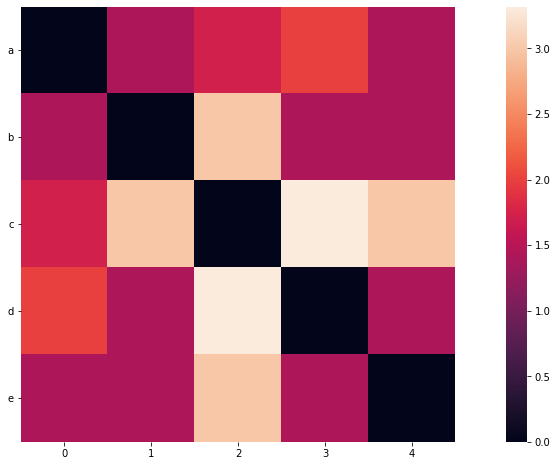

In [17]:
dist_heatmap(dm, labels)

With the tooling developed to look at these, I think we can move onto the first type of language model.

## USE Embeddings

Lets start with the first embedding method, The Universal Sentence Encoder - also know as USE. USE is really simple to use. Its a model hosted by [Tensorflow hub](https://tfhub.dev/google/universal-sentence-encoder-large/5). You can download it yourself, and just install the library. It works both on GPU and CPU, and the setup of depencancies is specific to that setup, however usage is the same.

### Loading use

To load the USE model, you start by loading the relivant libaries.

In [18]:
from pathlib import Path
import tensorflow as tf
import tensorflow_hub as hub

Lets load the model. Its going to take some time, about a minute or two.

In [19]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

OSError: SavedModel file does not exist at: C:\Users\muher\AppData\Local\Temp\tfhub_modules\c9fe785512ca4a1b179831acb18a0c6bfba603dd\{saved_model.pbtxt|saved_model.pb}

### Testing its usage

Right, now that we have the model, lets test it out. First up we are going to use the model itself. The model usage is simple `use(["some text"])`. We should just get a tensorflow tensor back of size `1` by `512` - which is the set dimensions used in the embedding space. 

In [ ]:
use([text_1])

We can now do a bigger get, by inputing a list of texts. This case three.

In [20]:
use([text_1, text_2, text_3])

NameError: name 'use' is not defined

Now we get a tensor of dimension `3` - because we gave it three texts, by `512`.

These are fine if we are going to use the tensor for something else. Otherwise we are going to want a numpy array or a list. This is something we can do something with later in the dataframe. Lets use the function this time.

In [23]:
def use_embeddings(use, texts):
    return use(texts).numpy()

In [24]:
use_embeddings(use, [text_1, text_2, text_3])

array([[-0.10524747,  0.09755939, -0.02840294, ..., -0.00324478,
        -0.02781587, -0.04270547],
       [-0.04460534,  0.09316997, -0.0615067 , ..., -0.07677929,
        -0.01422599, -0.02024265],
       [-0.02162791,  0.11712936, -0.04010844, ...,  0.02929141,
        -0.02328968, -0.05162372]], dtype=float32)

Enough of the playing around, lets now embed the text we have decided on at the begining, and store it in an array called `use_array`. We can use this array to study the pairwise distances.

In [25]:
use_embeddings(use, text_df.text.values)

array([[-0.10524744,  0.09755936, -0.02840292, ..., -0.00324479,
        -0.02781588, -0.04270547],
       [-0.04460532,  0.09316996, -0.06150668, ..., -0.07677928,
        -0.01422599, -0.02024264],
       [-0.0216279 ,  0.11712934, -0.04010843, ...,  0.02929141,
        -0.02328968, -0.05162372],
       ...,
       [-0.13694282,  0.08961891, -0.06746341, ..., -0.02337589,
        -0.0347138 ,  0.01609795],
       [-0.07996983,  0.0921495 , -0.03228908, ..., -0.02830213,
        -0.0254243 ,  0.01745192],
       [-0.04375786,  0.12529384, -0.08447118, ..., -0.02303549,
        -0.0093408 , -0.01258325]], dtype=float32)

In [26]:
use_array = use_embeddings(use, text_df.text.values)

The pairwise distances matrix come from our function. Running the `use_array` through the `pairwise_dists` function will get us the result we want. We can then plot it out.

In [27]:
use_dm = pairwise_dists(use_array)

In [28]:
use_dm[:3,:3]

array([[0.        , 0.71492857, 1.14582038],
       [0.71492857, 0.        , 1.1361444 ],
       [1.14582038, 1.1361444 , 0.        ]])

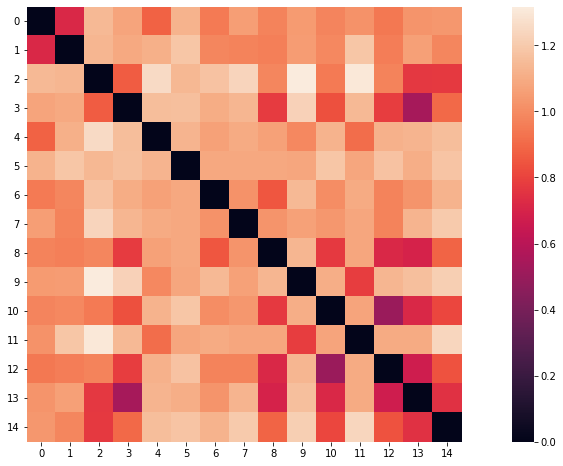

In [29]:
# wherever dist_heatmap is used, subsitute range(0, len(data)) for the second variable (tickmark labels)
dist_heatmap(use_dm, range(0, len(text_df.text)))

Okay, the text is a little small, and to help you not having to scroll, Lets print them out again below. However, what we can see is that darker colours imply embeddings that are closer together. Hence the diagonal is zero. The lightest colours are the most far away from each other. 

Then it isn't much of a suprise that we see the 5th sentence about speed limits being really distant from the others. The 4th is also pretty far away, but interestingly not as far.

When we have made the compound sentences, by adding the first sentences, we see that while they are close to each other there are still subtle differences the model picks up between - i.e. shades of dark. We can also see that while they are far from the first sentences they were added too, they are somewhat closer, as seen by the darker red than the other sentences. 

In [30]:
for i, text in enumerate(text_df.text.values):
    print(i+1, text)
    print()

1 36827   Based on review of records and interview, the facility failed to ensure an effective discharge planning process was developed and implemented. The facility failed to:   A. follow its own policy for initiating referrals to a Discharge Planner for focused discharge planning in 2 patients (Patient #1 and Patient #2) of two inpatient admissions reviewed.  Refer to Tag A0800   B. establish a discharge planning needs assessment for all patients identified as needing discharge planning.  Refer to Tag A0806   C. define the qualifications for personnel other than nurses or social workers who are performing discharge planning evaluations.  Refer to Tag A0807   D. ensure discharge planning evaluations were completed, documented, and placed in the patient charts for 2 (Patient #1 and Patient #2) of 2 patients reviewed.  Refer to Tag A0812    

2 28659  Based on interview and record review, the facility failed to    A. provide discharge planning for in-patient discharge needs for 4 of 4 m

### ASIDE: Dictionary and testing Out of Vocab (OOV) words 

You don't need to do this section if you are tight for time, its just a good way to see what this model does differently from the BERT model we will show later. We can extract the vocab from the USE model, and see if words are available to us. This isn't a common thing people do, but a hack that we have made so one can investigation of the model's limitations. You don't need to understand what the code is doing, but rather the process.

To do this we are going to use `importlib` and the tensorflow savedmodel loader. 

In [48]:
import importlib

We have to define the path to the model. This should be available if you have download the model in the steps above. If you don't get a path when running the cell below, you will have to go back and download.

In [49]:
use_dir = hub.resolve("https://tfhub.dev/google/universal-sentence-encoder-large/5")
print(use_dir)

C:\Users\muher\AppData\Local\Temp\tfhub_modules\c9fe785512ca4a1b179831acb18a0c6bfba603dd


First we load the model, and then we use extract the encodings from the graph (the model definition). We should have 200004 words in this.

In [50]:
loader_impl_large = importlib.import_module('tensorflow.python.saved_model.loader_impl')
saved_model_large = loader_impl_large.parse_saved_model(str(use_dir))

graph_large = saved_model_large.meta_graphs[0].graph_def
function_large = graph_large.library.function

node_type_large, node_value_large = function_large[0].node_def[0], function_large[0].node_def[1]
words_tensor_large = node_value_large.attr.get("value").tensor
word_list_large = set([i.decode('utf-8') for i in words_tensor_large.string_val])
print("Number of tokens is: {}".format(len(word_list_large)))

OSError: SavedModel file does not exist at: C:\Users\muher\AppData\Local\Temp\tfhub_modules\c9fe785512ca4a1b179831acb18a0c6bfba603dd\{saved_model.pbtxt|saved_model.pb}

Lets test this, to see if we are getting this work work properly. We have a set which contains the vocab in `word_list_large`. Lets try `immunohematology` and `Map`.

In [34]:
test_word = "immunohematology"
print("Is the Test Word in the vocabulary? {}".format(test_word in word_list_large))

Is the Test Word in the vocabulary? False


In [35]:
test_word = "map"
print("Is the Test Word in the vocabulary? {}".format(test_word in word_list_large))

Is the Test Word in the vocabulary? True


Feel free to test some words you can think of in your own line of work. Just cange the test word above.

If your test words aren't in there you might need to think about a different language model. However, its not always a big issue, and the pre training of the USE model is so good that often its better to stick with the model, rather than change because of a few fringe missing words.

# BERT

BERT has really shaken things up in the NLP world. The abilty of BERT and other transformer models was a step change in how NLP practitioners could solve NLP problems. With [Huggingface]() it got a whole load easier. In this part of the notebook we are going to use BERT to do some embedding of the text phrases we had above. We are going to compare them to USE. What I want is for you to understand:
1. How simple BERT is to use
2. What the differences are between BERT and USE
3. The strengths and weaknesses of the BERT method of embeddings.

Two things to note. This is just a stepping stone and not a full immersion. Firstly, while you might have gone through this and will hopefully have understood a little more about this, to actually apply these models in practice takes much more learning - and hopefully the bar has been lowered to start doing that.

Secondly, sadly this notebook is too short to do a good explaination of Transformers, and specifically BERT. However I can really recommend [Jay Alammar's](https://jalammar.github.io/illustrated-bert/) blog posts on how transformers and BERT work. Clearly only if you are interested.

## Tokenization
For the USE model, you didn't need to think about tokenization. If you did the little extra vocab excercise and reading, then you would have see that it is word by word. If the word isn't in the dictionary that USE has, then you simply have an out of vocab word. BERT is different, and we will need to tokenize the word first, before putting it into the model. Tokenization is simply converting the word into a series of numbers.

BERT is different from USE in that it splits the word down into small parts. This means that a word like `immunohematology` could potentially be split into `im`, `##mu`, `##no`, `##hem`, `##ato`, `##logy`. The double hash means it has a part of a word before it. This means that there are rarely any out of vocab words, and and even mispellings are often represented too.

So lets start by importing the `BertTokenizer`, `BertModel` from Huggingface's `transformer` library, along with `torch` which is Pytorch.

In [21]:
from transformers import BertTokenizer, BertModel
import torch

To intialize the tokenizer, we are simply going to create a `BertTokenizer` object, and use the `from_pretrained` method, where we specify the model type. In this case it is `bert-base-uncased`, but there are a whole host of options for us, including different langagues, and training methods.

In [22]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Why don't we begin by encoding the word `immunohematology` that was out of dictionary before. 

In [23]:
encoded_input = tokenizer(["immunohematology"], return_tensors='pt')

In [24]:
encoded_input

{'input_ids': tensor([[  101, 10047, 23041, 11631, 14545, 23479,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

What we have is a series of token id's called `input_ids`. These are `101`, `10047`, `23041`, `11631`, `14545`, `23479`, `102`. We can actually convert them back to see how the tokenizer has broken the word down. We also have `token_type_ids` and also the `attention mask`. At this stage you don't need to know what these last two are. If you are interested read the Jay Alammar blog entry.

In [25]:
encoded_input['input_ids'][0].tolist()

[101, 10047, 23041, 11631, 14545, 23479, 102]

In [26]:
print("  ID   |  Word")
print("------------------")
for wordpiece_id in encoded_input['input_ids'][0].tolist():
    print(f"{wordpiece_id:>5}  |  {tokenizer.decode([wordpiece_id])}")

  ID   |  Word
------------------
  101  |  [CLS]
10047  |  im
23041  |  ##mun
11631  |  ##oh
14545  |  ##ema
23479  |  ##tology
  102  |  [SEP]


Okay, so it would seem up above that I guessed wrong in how to split up the word. You will also see that we have two more things. These are the `[CLS]` and `[SEP]` tokens. These are used to show the model where the input text starts and finishes. For classifier models, people also use the `[CLS]` token output at the end of the as the input to the classifier.  

Now we have done the tokenization, we can move on to Model part.

### Model

The model takes the same form as the tokenizer. We initate the class from `BertModel`, and use the `from_pretrained` method to initate the model type. This much match the tokenizer. Note, there might be a warning that comes up. This is relivant in some cases, but not for what we are doing here.

In [23]:
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Next step is to feed the encoded input we had above to actually get an embedding. Lets feed it in, and see what we get.

In [43]:
output = model(**encoded_input)
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.2544,  0.1489, -0.7462,  ..., -0.2763,  0.2617,  0.6499],
         [-0.4337, -0.0894, -0.0847,  ..., -0.2189, -0.3531,  0.2842],
         [ 0.3402,  0.4620, -0.5363,  ..., -0.3578, -0.3536, -0.2290],
         ...,
         [ 0.4687, -0.0721,  0.2421,  ...,  0.2120, -0.0785,  0.6137],
         [ 0.0833, -0.2430, -1.1728,  ..., -0.2393, -0.1419, -0.3016],
         [ 0.7307,  0.0207, -0.3941,  ...,  0.0991, -0.5774, -0.1149]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-9.5228e-01, -6.3588e-01, -9.5724e-01,  8.7467e-01,  8.7168e-01,
         -4.3335e-01,  9.0874e-01,  3.9656e-01, -9.1047e-01, -1.0000e+00,
         -8.4032e-01,  9.8704e-01,  9.7915e-01,  6.9200e-01,  8.9423e-01,
         -9.0460e-01, -7.3887e-01, -7.2736e-01,  4.7684e-01, -3.4608e-01,
          7.9970e-01,  1.0000e+00, -4.8047e-01,  4.8356e-01,  6.2863e-01,
          9.9707e-01, -8.8253e-01,  8.9184e-01,  9.5383e-01,  8.165

Okay, so we get two things, namely `last_hidden_state`, and `pooler_output`. By looking at the shapes we get a good impression of what they both are.

In [44]:
output["last_hidden_state"].shape

torch.Size([1, 7, 768])

In [45]:
output["pooler_output"].shape

torch.Size([1, 768])

The `last_hidden_state` is the embedding of each wordpiece - if you look back you will see that there are 7 word pieces in `immunohematology`, In this case we can use `[CLS]`, i.e. the first token, as a representation of the text we have inputted.

Conversly `pooler_output` is all those embeddings pooled together, so we are left with just one vector, and that is the embedding of the text.

Lets see both those as embeddings for the sentences we have tested on the USE model previously.

In [24]:
# slice CMS_complaints to fit BERT word count of 512 
txt_short = [i[0:512] for i in text_df.text]

In [25]:
# bert_encoded_input = tokenizer(text_df.text.to_list(), padding=True, return_tensors='pt')

# pass in shortened list of complaint text
bert_encoded_input = tokenizer(txt_short, padding=True, return_tensors='pt')

In [26]:
bert_pooled_array = model(**bert_encoded_input)["pooler_output"].detach().numpy()
bert_pooled_array.shape

(15, 768)

In [27]:
bert_pooled_dm = pairwise_dists(bert_pooled_array)
bert_pooled_dm[:3,:3]

array([[0.        , 5.26906109, 5.68951321],
       [5.26906109, 0.        , 4.8199954 ],
       [5.68951321, 4.8199954 , 0.        ]])

In [28]:
bert_cls_array = model(**bert_encoded_input)["last_hidden_state"].detach().numpy()[:,0,:]
bert_cls_dm = pairwise_dists(bert_cls_array)

Okay, so with those two distance matricies made, lets looks at the heatmaps. Firstly with `pooled`, and then with `CLS`

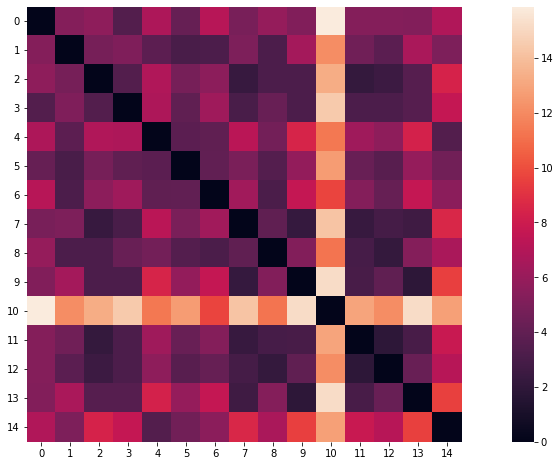

In [29]:
dist_heatmap(bert_pooled_dm, range(0, len(text_df.text)))

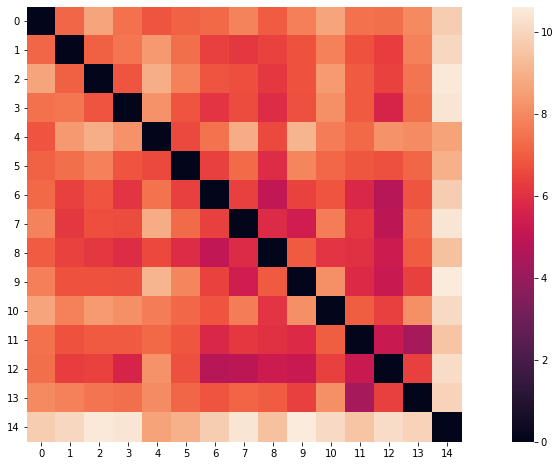

In [30]:
dist_heatmap(bert_cls_dm, range(0, len(text_df.text)))

In this case I would argue that `pooled` has performed worse that with `CLS`. This is mainly because we are seeing a differences between those first three sentences and the longer one from the road rules. If I plot the USE model results again below, you can see that the `CLS` has the that light line running down and across that the USE model has too.

In [31]:
dist_heatmap(use_dm, range(0, len(text_df.text)))

NameError: name 'use_dm' is not defined

However I would argue that none of these BERT are better than the USE model. That was kind of expected, because BERT isn't really designed to be used to create perfect embeddings out of the box. USE was trained and designed specifically to do that. 

Really BERT is much better at classification problems, or even finding masked words. But I hope you took three things out of this. Firstly that BERT isn't super scary to try and use, with a little more reading and playing around, you could try to start using it yourselves. Secondly that like all NLP problems (and I guess problems solving in general) you need to understand what is going on to see the potential pitfalls. Lastly, BERT has some real benifits over the USE model, espically when it comes to Vocab, but also what we haven't covered is that BERT can be trained and tailored to your language, while USE is what you get and nothing more.

I think its time to move to the next option, which is is to set up BERT to be able to train an embedding space.
 
 
## Sentence Transformers

When we started the previous project, the only options we had for Transformer based embeddings, were USE or BERT - as we have shown above, along with a method called Sentence-BERT which gave Sentence Embeddings from Siamese BERT-Networks. That last one while it sounds complicated was a method which used text pairs to train embeddings. For a given sentence you have to show a stentence which is the same, one that is different, and one that is neutral. This is great if you have that information, but normal text problems don't have that much labeled data in that format.

In the meantime an interesting developement has been made on that front which is an unsupervised approach called [SimCSE](https://www.sbert.net/examples/unsupervised_learning/SimCSE/README.html). This leverages the pretraining of BERT to develope embeddings from bert that are much more consistent than the ones above. Instead of training it on labeled text pairs we can just feed in some sentences. The result we hope is:

1. The benifits of BERTs full language and vocabulary
2. The benifits of a USE like embedding space.

So lets give it a go.

### Loading things up

To get this to work we are going to use the `sentence_transformers` library.

In [27]:
from sentence_transformers import SentenceTransformer, InputExample
from sentence_transformers import models, losses
from torch.utils.data import DataLoader

Now we can make our model object. The model we will choose is `bert-base-uncased`, and we are going to define our sentence transformer model using CLS pooling, with a maximum sequence length of 32 tokens. 

The format is a little different from the Huggingface method, so we define a `word_embedding_model` and a `pooling model`.

In [28]:
model_name = 'bert-base-uncased'
word_embedding_model = models.Transformer(model_name, max_seq_length=512)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Next up we can set up a list of sentences we are going to train from. These should be between 1,000 and 100,000 sentences, and clearly in the same text domain that we are interested in. What I have done is simply taken some abstracts from wikipedia on topics related to those I have seen in the test sentences.

In [29]:
sentence_text_wiki = pd.read_csv(r"C:/Users/muher/OneDrive - The Joint Commission/Desktop/tjc/tjc_tools/tjc_tools/observations.csv")

In [32]:
obs_txt = pd.DataFrame({"text":sentence_text_wiki["Observation Text"]})
std_txt = pd.DataFrame({"text": sentence_text_wiki["Standard Text"]})

In [33]:
trn_txt = pd.concat([obs_txt, std_txt], axis = 0).reset_index(drop = True)

In [34]:
x = trn_txt["text"].values.tolist()
sentence_text_wiki = "".join(x)

In [35]:
train_sentences_wiki = sentence_text_wiki.split(".")[0:100]

In [36]:
train_sentences_wiki = sentence_text_wiki.split(".")
len(train_sentences_wiki)

71646

Okay so we have way less than we are supposed to have, but its enough to get going. Lets see some of those training sentences.

In [37]:
train_sentences_wiki = sentence_text_wiki.split(".")[0:1000]

Now we need to convert the training sentences to sentence pairs, and put them into a data loader.

In [38]:
train_data_wiki = [InputExample(texts=[s, s]) for s in train_sentences_wiki]

In [39]:
train_dataloader_wiki = DataLoader(train_data_wiki, batch_size=128, shuffle=True)

Then we have everything we need to train the model up. Its just about setting up the loss function, in this case a denoising auto-encoder loss, and the `fit` method will do the hard work.

In [40]:
train_loss = losses.MultipleNegativesRankingLoss(model)

model.fit(
    train_objectives=[(train_dataloader_wiki, train_loss)],
    epochs=1,
    show_progress_bar=True
)

C:\Users\muher\Anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

In [44]:
#evaluating the model with validtation set
estimator.evaluate()

NameError: name 'estimator' is not defined

### Testing

Lets test this on the test sentences we developed earlier, and compaired the other models to. Then just print out the heat map.

In [45]:
sbert_wiki_array = model.encode(text_df.text.to_list())
sbert_wiki_array

array([[-0.3121638 ,  0.12723058,  0.14579877, ..., -0.08680201,
         0.01836274,  0.10837456],
       [-0.2843103 ,  0.08840432,  0.4196115 , ..., -0.19632833,
         0.10573903, -0.02470085],
       [-0.34921256,  0.04078646,  0.20651898, ...,  0.13737655,
         0.0896745 ,  0.10747889],
       ...,
       [-0.36644426,  0.1822883 ,  0.35002193, ..., -0.14053918,
         0.14485225,  0.00474648],
       [-0.37184244,  0.1625516 ,  0.27539283, ..., -0.09435476,
         0.04238422,  0.2534243 ],
       [-0.41905993,  0.15532357,  0.36564437, ..., -0.09286663,
         0.08958723,  0.06826548]], dtype=float32)

In [46]:
sbert_wiki_dm = pairwise_dists(sbert_wiki_array)
sbert_wiki_dm[:3,:3]

array([[0.        , 2.80399132, 4.43399429],
       [2.80399132, 0.        , 4.12736893],
       [4.43399429, 4.12736893, 0.        ]])

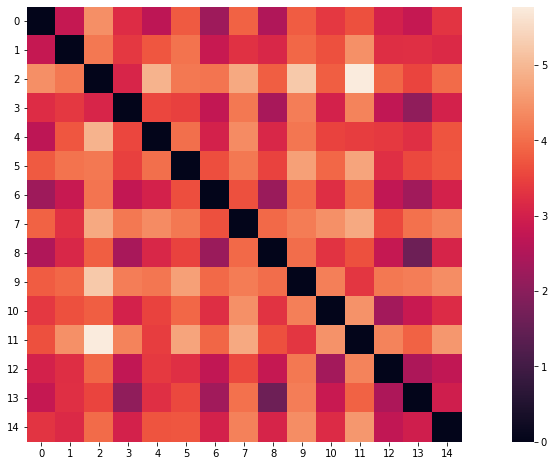

In [47]:
dist_heatmap(sbert_wiki_dm, range(0, len(text_df.text)))

That looks pretty good! Firstly you can see the big difference with this method, and the bert embeddings. They have improved massively. Secondly when we compair them to the USE model, there aren't really massive differences. From just 1 epoch of training and 200 sentences, we have achived something that on face value is about as good. See the heat map below.

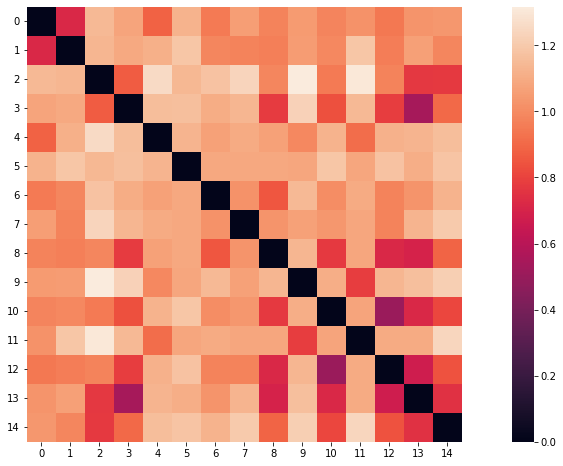

In [121]:
dist_heatmap(use_dm, range(0, len(text_df.text)))

So this Sentence Bert method is a really promising addition to the toolbox. It also comes with the advantage that it is tuneable to ones own data, and also has full vocab coverage. Its a really good sign.

**BUT** This is a toy example. You need to start trying this on your own data to see if this will be better. THis is where proper experimental methods will help give you a much more structured way to see if this method is better than USE, and what the pitfalls of this method are - because as always there will be some.

## Conclusion

In this workbook you have been guided through how to do state of the art embeddings in three different ways. I hope you have seen:

1. How easy they are to do
2. That much of the barrier to embeddings is in proper evaluation afterwards
3. That each method has its pros and cons.